<a href="https://colab.research.google.com/github/legendarychristian/GOOGL-LSTM-Analysis/blob/main/GOOGL_LSTM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install mplfinance
!pip install tensorflow

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import datetime as dt
import yfinance as yf
import seaborn as sns
import mplfinance as mpf
import matplotlib.pyplot as plt

#Data Retrieval & Processing

In [ ]:
# lets get the timeframe first -> getting today's date and the date that corresponds to 300 days prior
end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=300) #we use .timedelta for math involving a specific timeframe

# now we are going to format our dates
end_date = end_date.strftime("%Y-%m-%d")
start_date = start_date.strftime("%Y-%m-%d")
print()
print(f"beginning: {start_date} -> today: {end_date}")

# now lets get GOOGLE's stock information for the past 300 days
stock = 'GOOGL'
data = yf.download(stock, start_date, end_date)
df = pd.DataFrame(data=data)
df = df[['Close']]
df.index = pd.to_datetime(df.index)
df.head()

[*********************100%%**********************]  1 of 1 completed


beginning: 2023-04-03 -> today: 2024-01-28


,Close
Date,
2023-04-03,104.360001
2023-04-04,104.720001
2023-04-05,104.470001
2023-04-06,108.419998
2023-04-10,106.440002


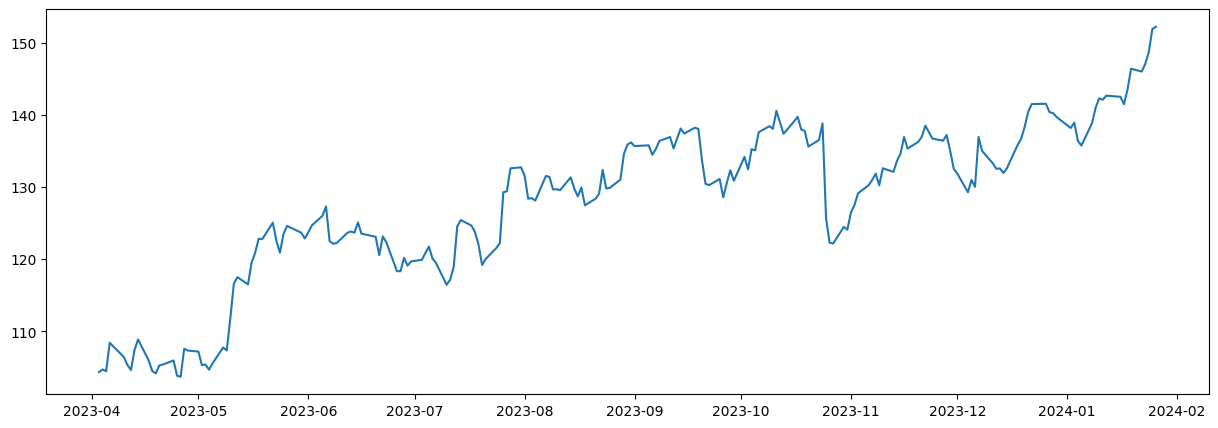

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(df.index,
         df['Close'])

#Formatting Data for the LSTM Neural Network


In [ ]:
end_date = dt.datetime.strptime(end_date, '%Y-%m-%d')
start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
start_date = start_date+dt.timedelta(days=3)

In [ ]:
import numpy as np

def rolling_window(df, start_date, end_date, n=3):
  dates = []
  X, Y = [], []

  target_date = start_date

  while True:
    df_subset = df.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    if target_date == df.index.max():
      break

    next_date = df.index[df.index > target_date].min()
    next_date = next_date.strftime("%Y-%m-%d")
    next_date = dt.datetime.strptime(next_date, '%Y-%m-%d')

    target_date = next_date


  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

windowed_df = rolling_window(df,
                                start_date,
                                end_date,
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2023-04-06,104.360001,104.720001,104.470001,108.419998
1,2023-04-10,104.720001,104.470001,108.419998,106.440002
2,2023-04-11,104.470001,108.419998,106.440002,105.349998
3,2023-04-12,108.419998,106.440002,105.349998,104.639999
4,2023-04-13,106.440002,105.349998,104.639999,107.430000
...,...,...,...,...,...
198,2024-01-22,141.470001,143.479996,146.380005,145.990005
199,2024-01-23,143.479996,146.380005,145.990005,147.039993
200,2024-01-24,146.380005,145.990005,147.039993,148.699997
201,2024-01-25,145.990005,147.039993,148.699997,151.869995


In [ ]:
# now we are going to shape our data into a matrix that is accepted by the LSTM network

def df_reshape(df):
  data = df.to_numpy()

  dates = data[:, 0]
  middle_matrix = data[:, 1:-1] # target-3 -> target_1
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)) # total rows of data, how many prices are "remembered", the price the "remembered" prices are determining
  Y = data[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = df_reshape(windowed_df)

dates.shape, X.shape, y.shape


((203,), (203, 3, 1), (203,))

#Creating Training, Testing, & Validation Sets

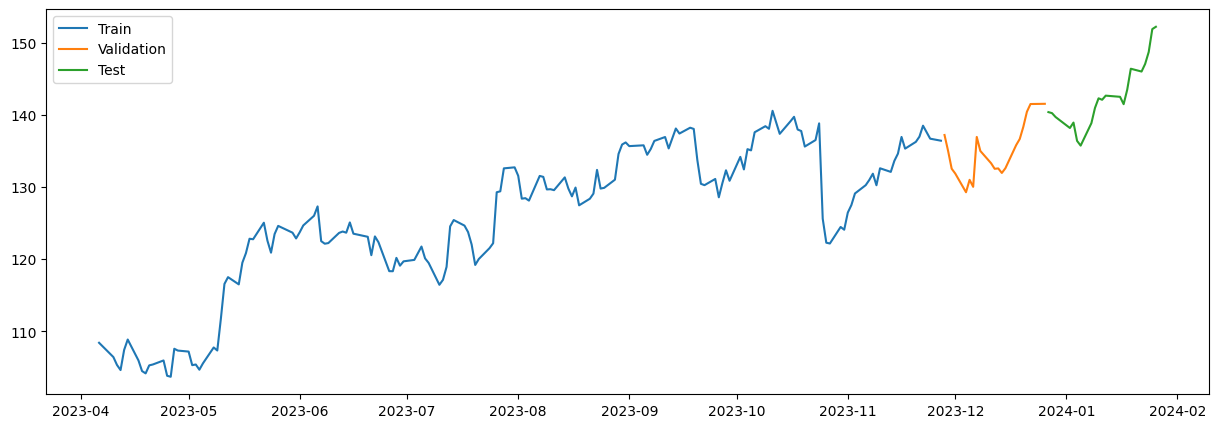

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.figure(figsize=(15,5))

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

#Training the LSTM Network


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
6/6 [==============================] - 4s 202ms/step - loss: 15673.9365 - mean_absolute_error: 124.7918 - val_loss: 17902.4570 - val_mean_absolute_error: 133.7522
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 15522.5928 - mean_absolute_error: 124.1853 - val_loss: 17732.2715 - val_mean_absolute_error: 133.1145
Epoch 3/100
6/6 [==============================] - 0s 21ms/step - loss: 15346.2578 - mean_absolute_error: 123.4715 - val_loss: 17505.4375 - val_mean_absolute_error: 132.2596
Epoch 4/100
6/6 [==============================] - 0s 39ms/step - loss: 15115.4922 - mean_absolute_error: 122.5307 - val_loss: 17219.0820 - val_mean_absolute_error: 131.1726
Epoch 5/100
6/6 [==============================] - 0s 23ms/step - loss: 14825.9736 - mean_absolute_error: 121.3483 - val_loss: 16861.6309 - val_mean_absolute_error: 129.8029
Epoch 6/100
6/6 [==============================] - 0s 24ms/step - loss: 14460.4385 - mean_absolute_error: 119.8259 - val_loss: 16

#Evaluating Our Model

6/6 [==============================] - 0s 3ms/step


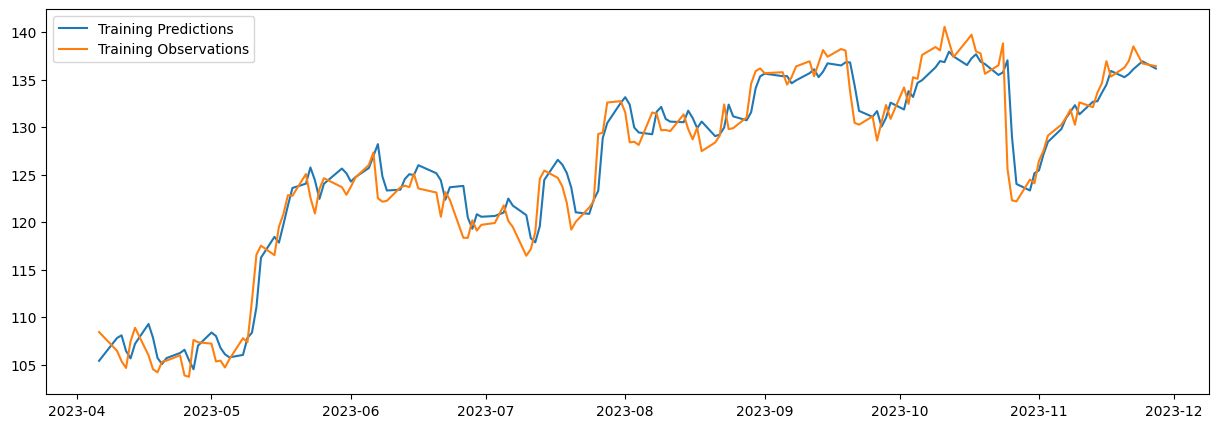

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize = (15, 5))

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 23ms/step


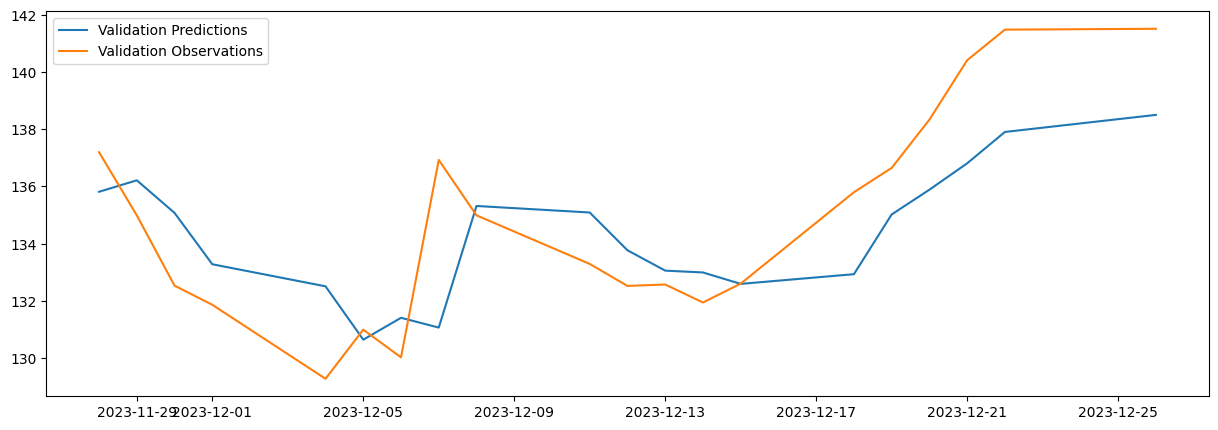

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize = (15, 5))

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 23ms/step


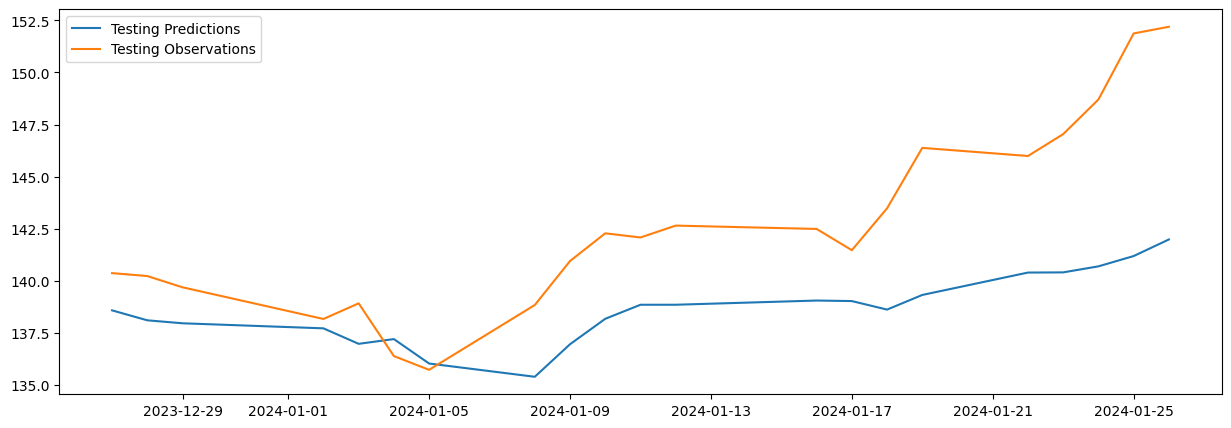

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize = (15, 5))

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

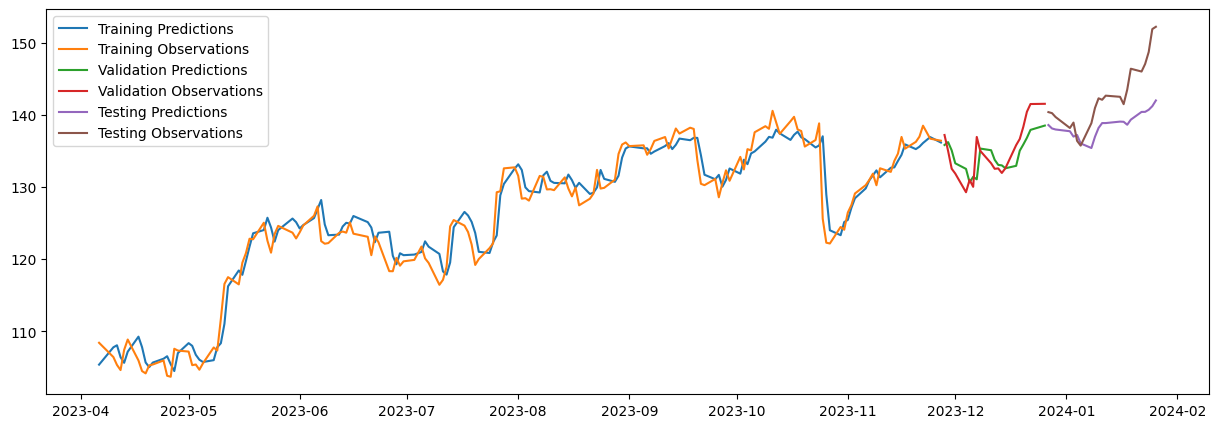

In [ ]:
plt.figure(figsize = (15, 5))

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])